In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

y_train_onehot = to_categorical(y_train, 10)
y_test_onehot = to_categorical(y_test, 10)

def train_and_evaluate_model(x_train, y_train, x_test, y_test, input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=0)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(x_test)
    infer_time = time.time() - start_time

    test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    return test_acc, train_time, infer_time

baseline_acc, baseline_train_time, baseline_infer_time = train_and_evaluate_model(
    x_train_flat, y_train_onehot, x_test_flat, y_test_onehot, input_dim=784
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

pca = PCA()
pca.fit(x_train_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

pca_acc, pca_train_time, pca_infer_time = train_and_evaluate_model(
    x_train_pca, y_train_onehot, x_test_pca, y_test_onehot, input_dim=n_components
)

results = {
    "Baseline Accuracy": baseline_acc,
    "PCA Accuracy": pca_acc,
    "Baseline Train Time (s)": baseline_train_time,
    "PCA Train Time (s)": pca_train_time,
    "Baseline Infer Time (s)": baseline_infer_time,
    "PCA Infer Time (s)": pca_infer_time,
    "Optimal n_components": n_components
}

df_results = pd.DataFrame([results])
print(df_results)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   Baseline Accuracy  PCA Accuracy  Baseline Train Time (s)  \
0             0.8874        0.8846                31.588763   

   PCA Train Time (s)  Baseline Infer Time (s)  PCA Infer Time (s)  \
0           37.030099                   2.7616            0.637025   

   Optimal n_components  
0                   256  


In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

file_path = "/content/train (2).csv"
df = pd.read_csv(file_path)

df.drop(columns=['uid'], inplace=True)

imputer = SimpleImputer(strategy='median')
df.iloc[:, 1:] = imputer.fit_transform(df.iloc[:, 1:])

label_encoder = LabelEncoder()
df['day'] = label_encoder.fit_transform(df['day'])

X = df.drop(columns=["output_electricity_generation"])
y = df["output_electricity_generation"]

var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X)
selected_features_var = X.columns[var_thresh.get_support()]

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]
X_corr = X.drop(columns=high_corr_features)
selected_features_corr = X_corr.columns

model = LinearRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=8, direction="forward", cv=5)
sfs.fit(X, y)
selected_features_greedy = X.columns[sfs.get_support()]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features_model = feature_importances.nlargest(8).index

rfe = RFE(estimator=LinearRegression(), n_features_to_select=8)
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]

selected_features = {
    "Variance Thresholding": list(selected_features_var),
    "Correlation Filtering": list(selected_features_corr),
    "Greedy Selection": list(selected_features_greedy),
    "Model-Based Importance": list(selected_features_model),
    "Recursive Feature Elimination": list(selected_features_rfe),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
start_time = time.time()
model.fit(X_train, y_train)
baseline_train_time = time.time() - start_time
y_pred = model.predict(X_test)
baseline_mse = mean_squared_error(y_test, y_pred)

results = {}
for method, features in selected_features.items():
    X_train_fs, X_test_fs = X_train[features], X_test[features]

    start_time = time.time()
    model.fit(X_train_fs, y_train)
    train_time = time.time() - start_time

    y_pred_fs = model.predict(X_test_fs)
    mse = mean_squared_error(y_test, y_pred_fs)

    results[method] = {
        "MSE": mse,
        "Train Time (s)": train_time
    }

results["Baseline"] = {
    "MSE": baseline_mse,
    "Train Time (s)": baseline_train_time
}

df_results = pd.DataFrame(results).T
print(df_results)

                                       MSE  Train Time (s)
Variance Thresholding          2046.952564        0.014489
Correlation Filtering          2034.435544        0.013996
Greedy Selection               2113.598081        0.010629
Model-Based Importance         3274.899729        0.009519
Recursive Feature Elimination  2146.150825        0.009847
Baseline                       2034.435544        0.015322


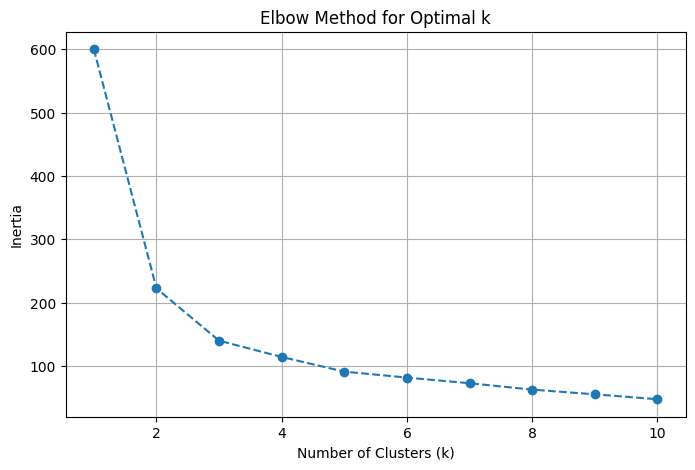

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import mode

iris = load_iris()
X = iris.data
y_true = iris.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [4]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

def get_cluster_accuracy(y_true, y_kmeans, k):
    labels = np.zeros_like(y_kmeans)
    for i in range(k):
        mask = (y_kmeans == i)
        labels[mask] = mode(y_true[mask])[0]
    return accuracy_score(y_true, labels)

kmeans_accuracy = get_cluster_accuracy(y_true, y_kmeans, optimal_k)

print("Optimal Number of Clusters (k):", optimal_k)
print("K-Means Clustering Accuracy:", kmeans_accuracy)


Optimal Number of Clusters (k): 3
K-Means Clustering Accuracy: 0.8333333333333334
